# Part 1. Сбор данных


## Parsing the data from websites with reviews

1. **Choose a product, a brand or an industry**.

Выбираем какую-то кофейню и их ближайших конкурентов в районе, доли рынка смотрим по какой-нибудь статье, публичному анализу рынка

2. **Parse the data from websites with reviews**.

Парсим данные с Яндекса и забираем отзывы оттуда + рейтинг в баллах (по нему потом считаем NPS)

3. **Data preprocessing**

Все ясно, но метод анализa: **sentiment analysis and opinion mining**


In [ ]:
import time
import pandas as pd
from selenium import webdriver
import google_colab_selenium as gs
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.action_chains import ActionChains

Yandex карты содержат контент, изменяемый динамически, поэтому использовать Beautiful Soup будет недостаточно.

Одним из основных достоинств Selenium является его способность обрабатывать динамически загружаемый контент на веб-страницах. В отличие от Beautiful Soup, который предназначен для работы с статическим HTML, Selenium может взаимодействовать с элементами страницы, которые подгружаются через JavaScript - позволяет эмулировать действия пользователя в браузере, в нашем случае полезным окажется прокрутка страниц.

In [ ]:
class CafeReviewScraper:
    def __init__(self, url, cafe_name):
        self.url = url
        self.cafe_name = cafe_name
        self.driver = gs.UndetectedChrome()
        self.driver.get(self.url)
        self.driver.maximize_window()
        self.driver.implicitly_wait(0.3)

    def scroll_and_collect_reviews(self):
        # 40 - это последний отзыв, доступный без учета прокрутки
        initial_selector = "div.business-reviews-card-view__reviews-container > div:nth-child(40)"
        element = self.driver.find_element(By.CSS_SELECTOR, initial_selector)
        self.driver.execute_script(f"document.querySelector('{initial_selector}').scrollIntoView();")
        time.sleep(1)

        all_reviews = []
        cafe_reviews = pd.DataFrame()

        current_index = 40

        ## запускаем цикл, чтобы крутить и собирать до тех пор, пока крутить будет нечего и драйвер при выполнении .execute_script выдаст ошибку
        while True:
            new_index = current_index + 10
            new_element = f"div.business-reviews-card-view__reviews-container > div:nth-child({current_index})"
            try:
                #пролистали страничку до current_index + 10 отзыва (= элемента)
                self.driver.execute_script(f"document.querySelector('{new_element}').scrollIntoView();")
                time.sleep(1)

                # нашли все отзывы, количество отзывов, их рейтинги и соответствующие даты (!) на страничке длиной current_index + 10 (!)
                reviews = self.driver.find_elements(By.CSS_SELECTOR, "div.business-review-view__body > span:nth-child(2) > div > span > span")
                current_reviews_length = len(reviews)

                rating_values = self.driver.find_elements(By.CSS_SELECTOR, "div.business-review-view__header > div > span > meta:nth-child(3)")
                dates = self.driver.find_elements(By.CSS_SELECTOR, "div.business-review-view__header > span > meta")

                # прошлись по всем доступным на данной итерации данным: отзывы, рейтинги и соответствующие даты (!) на страничке длиной current_index + 10 (!)
                for i in range(current_reviews_length):
                    review = reviews[i].text
                    rating_value = rating_values[i].get_attribute('content')
                    date = dates[i].get_attribute('content')

                    # Берем только те отзывы, которых еще не было на предыдущих итерациях = новые
                    if review not in all_reviews:
                        all_reviews.append(review)
                        info = {
                            'Отзыв': review,
                            'Рейтинг': rating_value,
                            'Дата': date,
                            'Кофейня': self.cafe_name
                        }
                        cafe_reviews = pd.concat([cafe_reviews, pd.DataFrame([info])], ignore_index=True)

                # print(f'Прокрутили и добавили уникальные элементы до {current_index}')
                current_index = new_index
                # print(f'Прокручиваем до элемента номер {current_index}...')
            except:
                print(f"Ура! Достигли конца страницы для {self.cafe_name}")
                break
        cafe_reviews.dropna(inplace=True)
        cafe_reviews['Дата'] = pd.to_datetime(cafe_reviews['Дата']).dt.date
        return cafe_reviews

**Создаем объект для каждой кофейни и применяем соответствующие методы для сбора**

достаточно указать url и название заведения

In [ ]:
# Star Hit Cafe
star_hit_url = "https://yandex.ru/maps/org/star_hit_cafe/1399440972/reviews/?ll=37.610383%2C55.721231&z=14"
star_hit_scraper = CafeReviewScraper(star_hit_url, "Star Hit Cafe")
star_hit_cafe_reviews = star_hit_scraper.scroll_and_collect_reviews()

# Surf Coffee
surf_url = "https://yandex.ru/maps/org/surf_coffee_x_secret_spot/143531603665/reviews/?ll=37.611765%2C55.721672&z=16"
surf_scraper = CafeReviewScraper(surf_url, "Surf Coffee")
surf_coffee_reviews = surf_scraper.scroll_and_collect_reviews()

# Prime
prime_url = "https://yandex.ru/maps/org/prime/173851548146/reviews/?ll=37.609379%2C55.720730&z=16"
prime_scraper = CafeReviewScraper(prime_url, "Prime")
prime_reviews = prime_scraper.scroll_and_collect_reviews()

all_reviews = pd.concat([prime_reviews, star_hit_cafe_reviews, surf_coffee_reviews], ignore_index=True)

# приведение дат и рейтингов в красивую форму
all_reviews['Дата'] = pd.to_datetime(all_reviews['Дата']).dt.date
all_reviews['Рейтинг'] = all_reviews['Рейтинг'].astype(int)
all_reviews.to_csv('raw_sentiment_reviews.csv')
all_reviews.tail()

<IPython.core.display.Javascript object>

Ура! Достигли конца страницы для Star Hit Cafe


<IPython.core.display.Javascript object>

Ура! Достигли конца страницы для Surf Coffee


<IPython.core.display.Javascript object>

Ура! Достигли конца страницы для Prime


,Отзыв,Рейтинг,Дата,Кофейня
1149,Здесь можно зависнуть на весь день,5.0,2019-05-06,Surf Coffee
1150,Бывает и лучше,4.0,2019-09-26,Surf Coffee
1151,Идеальный вайб,5.0,2019-10-01,Surf Coffee
1152,Отличный кофе.,5.0,2019-06-14,Surf Coffee
1153,вкусный кофе,5.0,2018-07-31,Surf Coffee


# Part 3. Data preprocessing


**загрузка данных и перевод на англ**

Так как интересно поработать с моделью для английского языка, дополнительно переведем отзывы на английский: однако будем обрабатывать оба варианта

In [ ]:
all_reviews = pd.read_csv('/content/all_reviews.csv')

In [ ]:
import os
import json
from deep_translator import GoogleTranslator

all_reviews.dropna(inplace=True)

translator = GoogleTranslator(source='auto', target='en')

all_reviews["Отзыв_англ"] = all_reviews["Отзыв"].apply(lambda x: translator.translate(x, lang_tgt="en"))

In [ ]:
# поменяем порядок столбцов, чтобы было красиво
all_reviews = all_reviews.reindex(columns=['Кофейня', 'Рейтинг', 'Отзыв', 'Отзыв_англ', 'Дата'])
all_reviews['Рейтинг'] = all_reviews['Рейтинг'].astype(float).apply(lambda x: str(x).rstrip('0.'))

all_reviews.tail()

,Кофейня,Рейтинг,Отзыв,Отзыв_англ,Дата
1149,Surf Coffee,5,Здесь можно зависнуть на весь день,You can hang out here all day long,2019-05-06
1150,Surf Coffee,4,Бывает и лучше,It could be better,2019-09-26
1151,Surf Coffee,5,Идеальный вайб,Perfect vibe,2019-10-01
1152,Surf Coffee,5,Отличный кофе.,Excellent coffee.,2019-06-14
1153,Surf Coffee,5,вкусный кофе,delicious coffee,2018-07-31


Основная информация:

**Кофейня**: Метка заведения

**Отзыв**: Текст отзыва, который отражает мнение клиента о качестве услуг или продукции кофейни.

**Рейтинг**: Оценка, присвоенная клиентом (например, "5"), отображающая уровень удовлетворенности клиента по шкале от 1 до 5, где 5 — наивысшая оценка.

**Дата**: Дата, когда был оставлен отзыв (например, "2021-04-02"), что позволяет отслеживать временные изменения в качестве услуг или отзывов.

## 3.1 Предобработка текста

**предобработка русского языка: pymorphy2 и NLTK**

Pymorphy2 умеет:

* приводить слово к нормальной форме (например, “люди -> человек”, или “гулял -> гулять”).
* ставить слово в нужную форму. Например, ставить слово во множественное число, менять падеж слова и т.д.
* возвращать грамматическую информацию о слове (число, род, падеж, часть речи и т.д.)

При работе используется *словарь OpenCorpora*; для незнакомых слов строятся гипотезы.

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Скачиваем данные, необходимые для работы библиотеки
nltk.download('stopwords')
nltk.download('punkt_tab') # для токенизации текста для nltk.word_tokenize()
# nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_rus') # модель для определения частей речи (POS-тегирования) на русском языке
nltk.download('wordnet') # загружает лексическую базу данных английского языка, которая содержит слова и их взаимосвязи, такие как синонимы, антонимы и леммы
nltk.download('omw-1.4') #позволяет использовать многоязычные данные для анализа.

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_rus to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_rus is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


* избавимся от букв латинского алфавита, чисел, знаков препинания и всех символов

* разобьем пост на токены

* проведем лемматизацияю, получив лемму (начальную) форму слова

* удалим стоп-слова

Без правильного POS-тега **WordNet Lemmatizer** использует стандартные правила, которые могут не учесть все контексты, что нашей задачей даёт неточные результаты.

In [ ]:
import re

from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords

# чтобы избавиться от всех некириллических символов и используется в функции re.sub
patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")

# Переменная morph – это морфологический анализатор, который используется для нахождения нормальной формы слова
morph = MorphAnalyzer()

def preprocessing_pipeline(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]

            tokens.append(token)

    if len(tokens) > 2:
        return ' '.join([token for token in tokens])
    return None

In [ ]:
text = "Очищаем от лишних \n и знаков, пунктуации и стоп-слов например а и от над еще !!!!"

In [ ]:
preprocessed_text = preprocessing_pipeline(text)
preprocessed_text

'очищать лишний знак пунктуация стоп слово например'

In [ ]:
all_reviews["Отзыв"] = all_reviews["Отзыв"].apply(preprocessing_pipeline)
all_reviews.tail(10)

,Кофейня,Рейтинг,Отзыв,Отзыв_англ,Дата
1144,Surf Coffee,5,любимый кофейня ♥️,Favorite coffee shop ♥️,2019-12-11
1145,Surf Coffee,5,None,good coffee,2020-09-09
1146,Surf Coffee,4,лето классный шезлонг двор,In the summer they have great sun loungers in ...,2019-01-05
1147,Surf Coffee,5,большой какао овсяный молоко себя 🥤,Large cocoa with oat milk to go 🥤,2019-06-12
1148,Surf Coffee,5,None,Arrow,2021-03-29
1149,Surf Coffee,5,здесь зависнуть весь день,You can hang out here all day long,2019-05-06
1150,Surf Coffee,4,None,It could be better,2019-09-26
1151,Surf Coffee,5,None,Perfect vibe,2019-10-01
1152,Surf Coffee,5,None,Excellent coffee.,2019-06-14
1153,Surf Coffee,5,None,delicious coffee,2018-07-31


В итоге имеем предобработанные русские отзывы и сырые английские

In [ ]:
# Удаляем строки с None в столбце "Отзыв"
filtered_reviews = all_reviews[all_reviews["Отзыв"].notna()]

# Удаляем столбец "Отзыв_англ"
# filtered_reviews = filtered_reviews.drop(columns=["Отзыв_англ"])

# Создаем новый DataFrame ru_all_reviews
ru_all_reviews = filtered_reviews.copy()
ru_all_reviews.tail(10)

,Кофейня,Рейтинг,Отзыв,Отзыв_англ,Дата
1133,Surf Coffee,5,обожать родный место,I love it) my native place,2020-06-26
1136,Surf Coffee,5,очень атмосферный рекомендовать,Very atmospheric))) I recommend it!,2020-06-16
1137,Surf Coffee,5,очень вкусный кофе довольно дешёвый,"Very tasty coffee, but not cheap!",2018-10-25
1139,Surf Coffee,5,безумно дружный коллектив зайка спидти топ,"Incredibly friendly team, all bunnies. Speedy top",2018-07-29
1141,Surf Coffee,5,очень вкусный какао,Very tasty cocoa,2020-05-02
1142,Surf Coffee,3,высокий цена маленький порция посредственный кофе,High prices for small portions of mediocre cof...,2019-02-13
1144,Surf Coffee,5,любимый кофейня ♥️,Favorite coffee shop ♥️,2019-12-11
1146,Surf Coffee,4,лето классный шезлонг двор,In the summer they have great sun loungers in ...,2019-01-05
1147,Surf Coffee,5,большой какао овсяный молоко себя 🥤,Large cocoa with oat milk to go 🥤,2019-06-12
1149,Surf Coffee,5,здесь зависнуть весь день,You can hang out here all day long,2019-05-06


**предобработка англа со spaCy**

Рассмотрим изображение ниже.

Компоненты пайплайна **parser** и **ner** добавят информацию, излишнюю для задачи классификации, поэтому мы их disable.

Нас интересует только компонент **tokenizer**, который разбивает предложения на слова, и **tagger**, который присваивает каждому слову метку части речи в данном контексте - так мы сможем решить задачу лемматизации - приведение слов к начальной форме

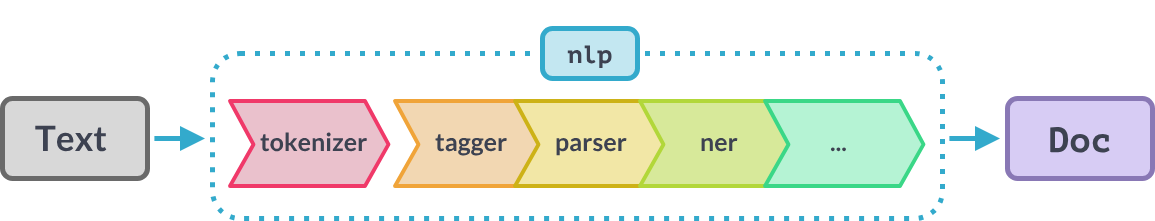

In [ ]:
import sys
!{sys.executable} -m pip install spacy
!{sys.executable} -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 30.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy
# Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
spacy_tagger_for_preprosessing = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [ ]:
import string
def clean_text(text):
    text_without_n = text.replace('\n', '')
    text_without_double_spaces = text_without_n.replace('  ', ' ')
    text_without_punctuation = text_without_double_spaces.translate(str.maketrans("", "", string.punctuation))
    return text_without_punctuation

def preprocessing_pipeline_with_spacy(text):
     # очищаем от лишних \n и знакова пунктуации
     cleaned_text = clean_text(text)

     # токенизация = разделение предложения на отдельные слова
     word_tokens = nltk.word_tokenize(cleaned_text)

     # удаление стоп-слов = слов, которые не несут вклад в семантику
     filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
     filtered_string = ' '.join([word for word in filtered_sentence])

     # лемматизация = приведение слов к начальной форме - применяем pipeline от spaCy (который выше называется nlp)
     doc = spacy_tagger_for_preprosessing(filtered_string)
     lemmatized_output = ' '.join([token.lemma_ for token in doc])
     return lemmatized_output

In [ ]:
# пример
text = "We clear out unnecessary \n and signs, punctuation and a and from above"

In [ ]:
preprocessed_text = preprocessing_pipeline_with_spacy(text)
preprocessed_text

'clear unnecessary sign punctuation'

In [ ]:
ru_all_reviews["Отзыв_англ"] = ru_all_reviews["Отзыв_англ"].apply(preprocessing_pipeline_with_spacy)
all_preprocessed_reviews = ru_all_reviews

In [ ]:
all_preprocessed_reviews.tail(15)

,Кофейня,Рейтинг,Отзыв,Отзыв_англ,Дата
1127,Surf Coffee,3,заведение тот волна фамильярный отношение посе...,establishment wave familiar attitude towards v...,2019-01-11
1128,Surf Coffee,5,прикольный местечко отличный атмосфера вкусный...,cool place great atmosphere delicious coffee,2018-06-29
1129,Surf Coffee,4,очень тесно равно очень уютный,cramp still cozy,2019-12-23
1130,Surf Coffee,5,отличный заведение весь рекомендовать,excellent establishment recommend everyone,2019-07-23
1132,Surf Coffee,5,очень вкусный дорога кофе,tasty inexpensive coffee,2020-03-03
1133,Surf Coffee,5,обожать родный место,love native place,2020-06-26
1136,Surf Coffee,5,очень атмосферный рекомендовать,atmospheric recommend,2020-06-16
1137,Surf Coffee,5,очень вкусный кофе довольно дешёвый,tasty coffee cheap,2018-10-25
1139,Surf Coffee,5,безумно дружный коллектив зайка спидти топ,incredibly friendly team bunnie Speedy top,2018-07-29
1141,Surf Coffee,5,очень вкусный какао,tasty cocoa,2020-05-02


In [ ]:
all_preprocessed_reviews.to_csv('AllClearedCoffeeReviews.csv', index=False)